## Objective of Notebook

**Find the best coefficients of a*iT + b*Lin (or a*DL + b*Lin) with respect to position**

* Using Exchange_rate dataset
* Analyze all data -> 0.7 train, 0.1 valid, 0.2 test
* 

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import os
import time
import json

# checkpoint -> result 불러오기
import argparse
from exp.exp_long_term_forecasting import Exp_Long_Term_Forecast
from exp.exp_imputation import Exp_Imputation
from exp.exp_short_term_forecasting import Exp_Short_Term_Forecast
from exp.exp_long_term_forecasting_partial import Exp_Long_Term_Forecast_Partial
from exp.exp_anomaly_detection import Exp_Anomaly_Detection
from exp.exp_classification import Exp_Classification
from utils.print_args import print_args
import random
from utils.metrics import *
from utils.tools import EarlyStopping

from utils.metrics import *
from utils.tools import linear_regression_direct, linear_predict
from data_provider.data_factory import data_provider
from data_provider.data_loader import Dataset_Custom

# 모델 훈련셋 결과 확인하기
from torch.utils.data import DataLoader

# 파서 불러오기
from commons.parser_write import *

# fix random seed
fix_seed = 2021
random.seed(fix_seed)
torch.manual_seed(fix_seed)
np.random.seed(fix_seed)

In [12]:
scripts_new = """--task_name long_term_forecast \
  --is_training 1 \
  --root_path ./dataset/weather/ \
  --data_path weather.csv \
  --model_id weather_96_96 \
  --model iTransformer  \
  --data custom \
  --features M \
  --seq_len 96 \
  --label_len 48 \
  --pred_len 96 \
  --e_layers 3 \
  --d_layers 1 \
  --factor 3 \
  --enc_in 21 \
  --dec_in 21 \
  --c_out 21 \
  --des 'Exp' \
  --d_model 512\
  --d_ff 512\
  --itr 1 """

args_list2 = []
arg = parser.parse_args(scripts_new.split())
arg.use_gpu = True if torch.cuda.is_available() and arg.use_gpu else False

if arg.use_gpu and arg.use_multi_gpu:
    arg.devices = arg.devices.replace(' ', '')
    device_ids = arg.devices.split(',')
    arg.device_ids = [int(id_) for id_ in device_ids]
    arg.gpu = arg.device_ids[0]

args_list2.append(arg)

In [13]:
weather_96_96_new = "long_term_forecast_weather_96_96_Mod-iTransformer_data-weather.csv_(96to96)_0(1728617672)"
setting_pairs = [
    (weather_96_96_new, args_list2[0])
]

In [14]:
# 역함수
def sigmoid_inverse(y):
    # y는 0과 1 사이의 값이어야 합니다.
    return np.log(y / (1 - y))

In [15]:
idx = 0 # 순서
col_count = 6 # 한 에포크당 수집 데이터 수
num_epochs = 5 # 에포크 ㅅ횟수
use_gpu = 0 # 사용 GPU 번호 - 오류 잡기 위해 
# q1, q2 = "lin96", "lin24" # 앙상블 모델 텍스트
q1, q2 = "lin24", "lin96" # 앙상블 모델 텍스트
a_init , b_init = sigmoid_inverse(0.95), sigmoid_inverse(0.04)  # 초기값(sigmoid로변환할  것 감안)  
lr = 0.005 #SGD 사용시에는 lr값을 충분히 키워서 쓸 것. Adam일 때는 0.01 정도가 적합

### Data Input
* 70% Training data &rarr; iTransformer/DLinear &amp; Lin
* 10% 단위마다 최적 조합 비율을 찾아볼 것. [앞부분 0.1, 0.2, ..., 0.7 까지, 0.8부분, 0.9, 마지막 부분 ]

In [16]:
setting_path = setting_pairs[idx][0]
args = setting_pairs[idx][1]
args.gpu = use_gpu
# 모델 호출 - Exp_Long_Term_Forecast - exchange_96_96
exp_model = Exp_Long_Term_Forecast(args)
exp_model._build_model()
device = torch.device(f"cuda:{use_gpu}")
exp_model.model.device = device

Use GPU: cuda:0


In [17]:
# 위의 argument와 맞는 모델 호출
checkpoint_path = './checkpoints/'
model_path = f"{checkpoint_path}{setting_path}/checkpoint.pth"
model = torch.load(model_path, map_location="cuda:0")  # 0번 GPU로 매핑
exp_model.model.load_state_dict(model, strict=False)

# data_provider -> Exchange_rate
dataset_input = Dataset_Custom(args, args.root_path,
                                    flag='train', size=(args.seq_len, args.label_len, args.pred_len),
                                    features='M', data_path = args.data_path,
                                    target='OT', scale=True, freq='h', timeenc=0,
                                    seasonal_patterns=None, train_ratio=args.train_ratio, test_ratio=args.test_ratio)
dataset_input_test = Dataset_Custom(args, args.root_path,
                                    flag='test', size=(args.seq_len, args.label_len, args.pred_len),
                                    features='M', data_path = args.data_path,
                                    target='OT', scale=True, freq='h', timeenc=0,
                                    seasonal_patterns=None, train_ratio=args.train_ratio, test_ratio=args.test_ratio)

exp_model.model.eval()



dataset_input_loader = DataLoader(
            dataset_input,
            batch_size=args.batch_size,
            shuffle=True,
            num_workers=args.num_workers,
            drop_last=False)
dataset_input_test_loader = DataLoader(
            dataset_input_test,
            batch_size=1, # 모든 데이터셋을 확인해야 해서 batch_size를 강제로 1로 조정.
            shuffle=False,
            num_workers=args.num_workers,
            drop_last=False)
            
X_old = np.array([[t, 1] for t in range(-args.seq_len, 0)])  # X_old는 입력 feature, shape: [seq_len, 1]
X_new = np.array([[t, 1] for t in range(args.pred_len)])  # 예측을 위한 새로운 시간 변수
X_concat = np.concatenate([X_old, X_new], axis=0).reshape(-1)

In [18]:
# Combination 모델 제작, 2단계/3단계 대응
class CombinedModel(nn.Module):
    # 모델 정의 - 
    def __init__(self, res_A, res_B, res_C):
        super(CombinedModel, self).__init__()
        self.res_A = res_A  # iTransformer train_result
        self.res_B = res_B  # lin_reg_96 train_result
        self.res_C = res_C
        self.a = nn.Parameter(torch.ones(1, device=device)*a_init, requires_grad=True)
        self.b = nn.Parameter(torch.ones(1, device=device)*b_init, requires_grad=True)
        if res_C is not None:
            self.c = nn.Parameter(torch.ones(1, device=device)*(1-a_init -b_init), requires_grad=True)
        else:
            self.c = nn.Parameter(torch.ones(1, device=device)*0.0, requires_grad=True)
        # self.c = nn.Parameter(torch.ones(1, device=device)*0.0, requires_grad=True)
        # self.d = nn.Parameter(torch.zeros(1, device=device), requires_grad=True)
        self.a_sigmoid = torch.sigmoid(self.a)
        self.b_sigmoid = torch.sigmoid(self.b)
    
    def set_a(self, val):
        # nn.Parameter를 다시 생성하지 않고 값을 설정
        with torch.no_grad():
            self.a.copy_(torch.tensor([val], device=device))

    def set_b(self, val):
        # nn.Parameter를 다시 생성하지 않고 값을 설정
        with torch.no_grad():
            self.b.copy_(torch.tensor([val], device=device))
            
    def forward(self, x):
        output_A = self.res_A(x)
        output_B = self.res_B(x)
        
        # Apply sigmoid to ensure non-negative coefficients in range (0, 1)
        a_sigmoid = torch.sigmoid(self.a)
        b_sigmoid = torch.sigmoid(self.b)
        
        # Ensure the sum constraint by defining c as the remainder
        c_sigmoid = torch.clamp(1 - a_sigmoid - b_sigmoid, min=0, max=1)
    
        # Compute the combined output with updated a, b, c
        # print(output_A.shape, output_B.shape)

        
        combined_output = a_sigmoid * output_A + b_sigmoid * output_B
        
        self.a_sigmoid = a_sigmoid
        self.b_sigmoid = b_sigmoid
        
    
        if self.res_C is not None:
            output_C = self.res_C(x)
            combined_output += c_sigmoid * output_C
        
        # Compute the combined output with updated a, b, c
        # combined_output = a_sigmoid * output_A + b_sigmoid * output_B + c_sigmoid * (self.res_C(x) if self.res_C else 0)
    
        return combined_output
    
    def get_result(self):
        a, b = self.a_sigmoid.detach().cpu().numpy()[0], self.b_sigmoid.detach().cpu().numpy()[0]
        return a,b

### 위치에 따라 수렴하는 계수가 달라지는 지 확인하기
* 0 ~ 0.1, 0.1 ~ 0.2, 

In [20]:
# model_output_function

def res_iTransformer(batch_x): # S 
    B, L, N = batch_x.shape  # L은 시퀀스 길이(seq_len)
    return exp_model.model(batch_x, None, torch.zeros(B, len(X_new), N), None).permute(0, 2, 1) 

def res_lin_reg(batch_x, reg_size=96):
    B, L, N = batch_x.shape  # B: Batch size, L: Sequence length, N: Number of variables

    device = batch_x.device

    # Prepare the regression input for the last `reg_size` elements from X_old
    X_torch = torch.tensor(X_old[-reg_size:], dtype=torch.float32, device=device)  # Shape: [reg_size, 2]

    # Initialize tensor for storing results
    lin_result = torch.zeros((B, X_new.shape[0], N), device=device)  # Shape: [B, pred_len, N]

    # Convert X_new to a tensor once outside the loop
    X_new_torch = torch.tensor(X_new, dtype=torch.float32, device=device)  # Shape: [pred_len, 2]

    # Perform batched linear regression for each batch and variable
    for idx in range(B):
        # Get the y_torch values for all variables in one operation
        y_torch = batch_x[idx, -reg_size:, :].to(device)  # Shape: [reg_size, N]

        # Compute least squares in batch for all variables at once
        # torch.linalg.lstsq can handle multiple right-hand sides (N variables)
        w = torch.linalg.lstsq(X_torch, y_torch).solution  # Shape: [2, N] (2 coefficients per variable)

        # Make predictions over the entire X_new using batch matrix multiplication
        lin_result[idx, :, :] = X_new_torch @ w  # Shape: [pred_len, N]

    return lin_result.permute(0, 2, 1)  # Return in shape [B, N, pred_len]

def zero_model(batch_x): # S 길이
    B, L, N = batch_x.shape  # L은 시퀀스 길이(seq_len)
    return torch.zeros(B, len(X_new), N)

# 함수 도출
def get_res_lin(reg_size):
    global X_new
    def fn(batch_x):
        return res_lin_reg(batch_x, reg_size)
    
    return fn

QMAP_FN = {
  "none": None,
  "lin12" : get_res_lin(12),
  "lin24" : get_res_lin(24),
  "lin48" : get_res_lin(48),
  "lin96" : get_res_lin(96),
  "lin" : get_res_lin(96),
}

In [21]:
# 우선 train_set의 data_exchange를 바탕으로 측정값 참값 가져기
# 트레인 데이터셋을 테스트해서 결과 받기, test 함수에서 가져옴
preds_te_tr = [] # 예측값
trues_te_tr = [] # 참값
preds_te_lin = [] # 96_lin
preds_te_lin_48 = [] # 48_lin
preds_te_lin_24 = [] # 24_lin
preds_te_lin_12 = [] # 24_lin

start_time = time.time() # 시작타
print(f"iteration start, time : {time.localtime()}")

for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(dataset_input_loader):
    batch_x = batch_x.float().to(device)
    batch_y = batch_y.float().to(device)

    B, L, N = batch_x.shape  # L은 시퀀스 길이(seq_len)

    batch_x_mark = batch_x_mark.float().to(device)
    batch_y_mark = batch_y_mark.float().to(device)

    # decoder input
    dec_inp = torch.zeros_like(batch_y[:, -args.pred_len:, :]).float()
    dec_inp = torch.cat([batch_y[:, :args.label_len, :], dec_inp], dim=1).float().to(device)
    # encoder - decoder

    # use_amp도 사용하지 않음, 
    outputs = exp_model.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
    
    # 각 배치와 변수에 대해 선형 회귀 해를 계산
    lin_result = res_lin_reg(batch_x, 96).to(device)

    lin_result_24 = res_lin_reg(batch_x, 24).to(device)
    
    # 48 테스트
    lin_result_48 = res_lin_reg(batch_x, 48).to(device)
    
    # 12 테스트
    lin_result_12 = res_lin_reg(batch_x, 12).to(device)
    
    outputs = outputs[:, -args.pred_len:, :]
    batch_y = batch_y[:, -args.pred_len:, :].to(device)
    outputs = outputs.detach().cpu().numpy()
    batch_y = batch_y.detach().cpu().numpy()

    pred = outputs
    true = batch_y

    preds_te_tr.append(pred)
    trues_te_tr.append(true)
    preds_te_lin.append(lin_result)
    preds_te_lin_24.append(lin_result_24)
    preds_te_lin_48.append(lin_result_48)
    preds_te_lin_12.append(lin_result_12)

    if (i+1)%100==0:
        print(f"step {i+1} completed")

    
preds_te_tr = np.concatenate(preds_te_tr, axis=0)
trues_te_tr = np.concatenate(trues_te_tr, axis=0)
preds_te_lin = np.transpose(torch.concat(preds_te_lin, axis=0).detach().cpu().numpy(), (0,2,1))
preds_te_lin_24 = np.transpose(torch.concat(preds_te_lin_24, axis=0).detach().cpu().numpy(), (0,2,1))
preds_te_lin_48 = np.transpose(torch.concat(preds_te_lin_48, axis=0).detach().cpu().numpy(), (0,2,1))
preds_te_lin_12 = np.transpose(torch.concat(preds_te_lin_12, axis=0).detach().cpu().numpy(), (0,2,1))
input_len = i + 1

iteration start, time : time.struct_time(tm_year=2024, tm_mon=10, tm_mday=16, tm_hour=13, tm_min=36, tm_sec=16, tm_wday=2, tm_yday=290, tm_isdst=0)
step 100 completed
step 200 completed
step 300 completed
step 400 completed
step 500 completed
step 600 completed
step 700 completed
step 800 completed
step 900 completed
step 1000 completed
step 1100 completed


In [22]:
# validation data도 호출
dataset_input_val = Dataset_Custom(args, args.root_path,
                                    flag='val', size=(args.seq_len, args.label_len, args.pred_len),
                                    features='M', data_path = args.data_path,
                                    target='OT', scale=True, freq='h', timeenc=0,
                                    seasonal_patterns=None, train_ratio=args.train_ratio, test_ratio=args.test_ratio)
dataset_input_val_loader = DataLoader(
            dataset_input_val,
            batch_size=1, # 모든 데이터셋을 확인해야 해서 batch_size를 강제로 1로 조정.
            shuffle=False,
            num_workers=args.num_workers,
            drop_last=False)

In [23]:
# val_loader, test_loader 불러오기

# 우선 train_set의 data_exchange를 바탕으로 측정값 참값 가져기
# 트레인 데이터셋을 테스트해서 결과 받기, test 함수에서 가져옴
preds_te_tr_val = [] # 예측값
trues_te_tr_val = [] # 참값
preds_te_lin_val = [] # 96_lin
preds_te_lin_48_val = [] # 48_lin
preds_te_lin_24_val = [] # 24_lin
preds_te_lin_12_val = [] # 24_lin
preds_te_tr_test = [] # 예측값
trues_te_tr_test = [] # 참값
preds_te_lin_test = [] # 96_lin
preds_te_lin_48_test = [] # 48_lin
preds_te_lin_24_test= [] # 24_lin
preds_te_lin_12_test = [] # 24_lin

start_time = time.time() # 시작타
print(f"iteration start, time : {time.localtime()}")

for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(dataset_input_val_loader):
    batch_x = batch_x.float().to(device)
    batch_y = batch_y.float().to(device)

    B, L, N = batch_x.shape  # L은 시퀀스 길이(seq_len)

    batch_x_mark = batch_x_mark.float().to(device)
    batch_y_mark = batch_y_mark.float().to(device)

    # decoder input
    dec_inp = torch.zeros_like(batch_y[:, -args.pred_len:, :]).float()
    dec_inp = torch.cat([batch_y[:, :args.label_len, :], dec_inp], dim=1).float().to(device)
    # encoder - decoder

    # use_amp도 사용하지 않음, 
    outputs = exp_model.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
    
    # 각 배치와 변수에 대해 선형 회귀 해를 계산
    lin_result_val = res_lin_reg(batch_x, 96).to(device)

    lin_result_24_val = res_lin_reg(batch_x, 24).to(device)
    
    # 48 테스트
    lin_result_48_val = res_lin_reg(batch_x, 48).to(device)
    
    # 12 테스트
    lin_result_12_val = res_lin_reg(batch_x, 12).to(device)
    
    outputs = outputs[:, -args.pred_len:, :]
    batch_y = batch_y[:, -args.pred_len:, :].to(device)
    outputs = outputs.detach().cpu().numpy()
    batch_y = batch_y.detach().cpu().numpy()

    pred_val = outputs
    true_val = batch_y

    preds_te_tr_val.append(pred_val)
    trues_te_tr_val.append(true_val)
    preds_te_lin_val.append(lin_result_val)
    preds_te_lin_24_val.append(lin_result_24_val)
    preds_te_lin_48_val.append(lin_result_48_val)
    preds_te_lin_12_val.append(lin_result_12_val)

    if (i+1)%100==0:
        print(f"step {i+1} completed")

    
preds_te_tr_val = np.concatenate(preds_te_tr_val, axis=0)
trues_te_tr_val = np.concatenate(trues_te_tr_val, axis=0)
preds_te_lin_val = np.transpose(torch.concat(preds_te_lin_val, axis=0).detach().cpu().numpy(), (0,2,1))
preds_te_lin_24_val = np.transpose(torch.concat(preds_te_lin_24_val, axis=0).detach().cpu().numpy(), (0,2,1))
preds_te_lin_48_val = np.transpose(torch.concat(preds_te_lin_48_val, axis=0).detach().cpu().numpy(), (0,2,1))
preds_te_lin_12_val = np.transpose(torch.concat(preds_te_lin_12_val, axis=0).detach().cpu().numpy(), (0,2,1))
input_len_val = i + 1


for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(dataset_input_test_loader):
    batch_x = batch_x.float().to(device)
    batch_y = batch_y.float().to(device)

    B, L, N = batch_x.shape  # L은 시퀀스 길이(seq_len)

    batch_x_mark = batch_x_mark.float().to(device)
    batch_y_mark = batch_y_mark.float().to(device)

    # decoder input
    dec_inp = torch.zeros_like(batch_y[:, -args.pred_len:, :]).float()
    dec_inp = torch.cat([batch_y[:, :args.label_len, :], dec_inp], dim=1).float().to(device)
    # encoder - decoder

    # use_amp도 사용하지 않음, 
    outputs = exp_model.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
    
    # 각 배치와 변수에 대해 선형 회귀 해를 계산
    lin_result_test = res_lin_reg(batch_x, 96).to(device)

    lin_result_24_test = res_lin_reg(batch_x, 24).to(device)
    
    # 48 테스트
    lin_result_48_test = res_lin_reg(batch_x, 48).to(device)
    
    # 12 테스트
    lin_result_12_test = res_lin_reg(batch_x, 12).to(device)
    
    outputs = outputs[:, -args.pred_len:, :]
    batch_y = batch_y[:, -args.pred_len:, :].to(device)
    outputs = outputs.detach().cpu().numpy()
    batch_y = batch_y.detach().cpu().numpy()

    pred_test = outputs
    true_test = batch_y

    preds_te_tr_test.append(pred_test)
    trues_te_tr_test.append(true_test)
    preds_te_lin_test.append(lin_result_test)
    preds_te_lin_24_test.append(lin_result_24_test)
    preds_te_lin_48_test.append(lin_result_48_test)
    preds_te_lin_12_test.append(lin_result_12_test)

    if (i+1)%100==0:
        print(f"step {i+1} completed")

    
preds_te_tr_test = np.concatenate(preds_te_tr_test, axis=0)
trues_te_tr_test = np.concatenate(trues_te_tr_test, axis=0)
preds_te_lin_test = np.transpose(torch.concat(preds_te_lin_test, axis=0).detach().cpu().numpy(), (0,2,1))
preds_te_lin_24_test = np.transpose(torch.concat(preds_te_lin_24_test, axis=0).detach().cpu().numpy(), (0,2,1))
preds_te_lin_48_test = np.transpose(torch.concat(preds_te_lin_48_test, axis=0).detach().cpu().numpy(), (0,2,1))
preds_te_lin_12_test = np.transpose(torch.concat(preds_te_lin_12_test, axis=0).detach().cpu().numpy(), (0,2,1))
input_len_val = i + 1

iteration start, time : time.struct_time(tm_year=2024, tm_mon=10, tm_mday=16, tm_hour=13, tm_min=48, tm_sec=55, tm_wday=2, tm_yday=290, tm_isdst=0)
step 100 completed
step 200 completed
step 300 completed
step 400 completed
step 500 completed
step 600 completed
step 700 completed
step 800 completed
step 900 completed
step 1000 completed
step 1100 completed
step 1200 completed
step 1300 completed
step 1400 completed
step 1500 completed
step 1600 completed
step 1700 completed
step 1800 completed
step 1900 completed
step 2000 completed
step 2100 completed
step 2200 completed
step 2300 completed
step 2400 completed
step 2500 completed
step 2600 completed
step 2700 completed
step 2800 completed
step 2900 completed
step 3000 completed
step 3100 completed
step 3200 completed
step 3300 completed
step 3400 completed
step 3500 completed
step 3600 completed
step 3700 completed
step 3800 completed
step 3900 completed
step 4000 completed
step 4100 completed
step 4200 completed
step 4300 completed
s

In [31]:
# 이제 비율 확인하기 0.01 단위로.
from decimal import Decimal
# 0.5:0.5 ~ 1:0까지

jx = [Decimal('0') + Decimal(str(t))*Decimal('0.01') for t in range(101)]

print(len(preds_te_tr), len(preds_te_tr_val), len(preds_te_tr_test))

36696 5175 10444


In [32]:
float(jx[0])

0.0

In [25]:
from utils.metrics import *

In [38]:
# MAE, MSE, SMAE, SLOPE_RATIO 기준

train_div_num = (len(preds_te_tr)-1)//7 + 1
test_div_num = (len(preds_te_tr_test)-1)//2 + 1

metrics_train = dict()
metrics_val = dict()
metrics_test = dict()
min_val_trains = []
min_val_val = {"MAE": (0,100), "MSE": (0,100), "SMAE":(0,100), "SLOPE_RATIO": (0,100)} # coef, val
min_val_tests = []
# 형태 : (pos_proportion) 0_0.5 : {MSE:, MAE:, SMAE:, SLOPE_RATIO:}

# train
for u in range(7):
    min_val_train = {"MAE": (0,100), "MSE": (0,100), "SMAE":(0,100), "SLOPE_RATIO": (0,100)} # coef, val
    mse_temp = min_val_train["MSE"]
    mae_temp = min_val_train["MAE"]
    smae_temp = min_val_train["SMAE"]
    dslope_temp = min_val_train["SLOPE_RATIO"]
    
    for jxnum in jx:
        key_val = f"{u}_{str(jxnum)}"
        part_val = {"MSE":0, "MAE":0, "SMAE":0, "SLOPE_RATIO":0}
        preds_part = preds_te_tr[u*train_div_num:(u+1)*train_div_num]
        trues_part = trues_te_tr[u*train_div_num:(u+1)*train_div_num]
        lin_part = preds_te_lin[u*train_div_num:(u+1)*train_div_num]
        jxnum0 = float(jxnum)
        metrics_train[key_val] = {
            "MSE": MSE(jxnum0*preds_part + (1-jxnum0)*lin_part, trues_part),
            "MAE": MAE(jxnum0*preds_part + (1-jxnum0)*lin_part, trues_part),
            "SMAE": SMAE(jxnum0*preds_part + (1-jxnum0)*lin_part, trues_part),
            "SLOPE_RATIO": SLOPE_RATIO(jxnum0*preds_part + (1-jxnum0)*lin_part, trues_part),
        }

        # 계수 체체
        if metrics_train[key_val]["MSE"] < mse_temp[1]:
            mse_temp = (jxnum0, metrics_train[key_val]["MSE"])
            min_val_train["MSE"] = mse_temp
        if metrics_train[key_val]["MAE"] < mae_temp[1]:
            mae_temp = (jxnum0, metrics_train[key_val]["MAE"])
            min_val_train["MAE"] = mae_temp
        if metrics_train[key_val]["SMAE"] < smae_temp[1]:
            smae_temp = (jxnum0, metrics_train[key_val]["SMAE"])
            min_val_train["SMAE"] = smae_temp
        if metrics_train[key_val]["SLOPE_RATIO"] < dslope_temp[1]:
            dslope_temp = (jxnum0, metrics_train[key_val]["SLOPE_RATIO"])
            min_val_train["SLOPE_RATIO"] = dslope_temp

    # min_val_trains 채기기
    min_val_trains.append(min_val_train)

# val
mse_temp = min_val_val["MSE"]
mae_temp = min_val_val["MAE"]
smae_temp = min_val_val["SMAE"]
dslope_temp = min_val_val["SLOPE_RATIO"]

for jxnum in jx:        
    key_val = f"{0}_{str(jxnum)}"
    part_val = {"MSE":0, "MAE":0, "SMAE":0, "SLOPE_RATIO":0}
    preds_part = preds_te_tr_val
    trues_part = trues_te_tr_val
    lin_part = preds_te_lin_val
    jxnum0 = float(jxnum)
    metrics_val[key_val] = {
        "MSE": MSE(jxnum0*preds_part + (1-jxnum0)*lin_part, trues_part),
        "MAE": MAE(jxnum0*preds_part + (1-jxnum0)*lin_part, trues_part),
        "SMAE": SMAE(jxnum0*preds_part + (1-jxnum0)*lin_part, trues_part),
        "SLOPE_RATIO": SLOPE_RATIO(jxnum0*preds_part + (1-jxnum0)*lin_part, trues_part),
    }

    # 계수 체체
    if metrics_val[key_val]["MSE"] < mse_temp[1]:
        mse_temp = (jxnum0, metrics_val[key_val]["MSE"])
        min_val_val["MSE"] = mse_temp
    if metrics_val[key_val]["MAE"] < mae_temp[1]:
        mae_temp = (jxnum0, metrics_val[key_val]["MAE"])
        min_val_val["MAE"] = mae_temp
    if abs(metrics_val[key_val]["SMAE"]) < abs(smae_temp[1]):
        smae_temp = (jxnum0, metrics_val[key_val]["SMAE"])
        min_val_val["SMAE"] = smae_temp
    if abs(metrics_val[key_val]["SLOPE_RATIO"]) < abs(dslope_temp[1]):
        dslope_temp = (jxnum0, metrics_val[key_val]["SLOPE_RATIO"])
        min_val_val["SLOPE_RATIO"] = dslope_temp

#test
for v in range(2):
    min_val_test = {"MAE": (0,100), "MSE": (0,100), "SMAE":(0,100), "SLOPE_RATIO": (0,100)} # coef, val
    mse_temp = min_val_test["MSE"]
    mae_temp = min_val_test["MAE"]
    smae_temp = min_val_test["SMAE"]
    dslope_temp = min_val_test["SLOPE_RATIO"]
    
    for jxnum in jx:
        key_val = f"{v}_{str(jxnum)}"
        part_val = {"MSE":0, "MAE":0, "SMAE":0, "SLOPE_RATIO":0}
        preds_part = preds_te_tr_test[v*test_div_num:(v+1)*test_div_num]
        trues_part = trues_te_tr_test[v*test_div_num:(v+1)*test_div_num]
        lin_part = preds_te_lin_test[v*test_div_num:(v+1)*test_div_num]
        jxnum0 = float(jxnum)
        metrics_test[key_val] = {
            "MSE": MSE(jxnum0*preds_part + (1-jxnum0)*lin_part, trues_part),
            "MAE": MAE(jxnum0*preds_part + (1-jxnum0)*lin_part, trues_part),
            "SMAE": SMAE(jxnum0*preds_part + (1-jxnum0)*lin_part, trues_part),
            "SLOPE_RATIO": SLOPE_RATIO(jxnum0*preds_part + (1-jxnum0)*lin_part, trues_part),
        }
        
        # 계수 체체
        if metrics_test[key_val]["MSE"] < mse_temp[1]:
            mse_temp = (jxnum0, metrics_test[key_val]["MSE"])
            min_val_test["MSE"] = mse_temp
        if metrics_test[key_val]["MAE"] < mae_temp[1]:
            mae_temp = (jxnum0, metrics_test[key_val]["MAE"])
            min_val_test["MAE"] = mae_temp
        if abs(metrics_test[key_val]["SMAE"]) < abs(smae_temp[1]):
            smae_temp = (jxnum0, metrics_test[key_val]["SMAE"])
            min_val_test["SMAE"] = smae_temp
        if abs(metrics_test[key_val]["SLOPE_RATIO"]) < abs(dslope_temp[1]):
            dslope_temp = (jxnum0, metrics_test[key_val]["SLOPE_RATIO"])
            min_val_test["SLOPE_RATIO"] = dslope_temp

    min_val_tests.append(min_val_test)


In [34]:
jxnum

Decimal('0.00')

In [37]:
%whos

Variable                         Type                      Data/Info
--------------------------------------------------------------------
B                                int                       1
CORR                             function                  <function CORR at 0x7f27b0ce0310>
CombinedModel                    type                      <class '__main__.CombinedModel'>
DataLoader                       type                      <class 'torch.utils.data.dataloader.DataLoader'>
Dataset_Custom                   type                      <class 'data_provider.dat<...>a_loader.Dataset_Custom'>
Decimal                          type                      <class 'decimal.Decimal'>
EarlyStopping                    type                      <class 'utils.tools.EarlyStopping'>
Exp_Anomaly_Detection            type                      <class 'exp.exp_anomaly_d<...>n.Exp_Anomaly_Detection'>
Exp_Classification               type                      <class 'exp.exp_classific<...>tion.Exp_

In [27]:
len(preds_te_tr)/ len(preds_te_tr_val), len(preds_te_tr_test)/len(preds_te_tr_val)

(7.091014492753623, 2.0181642512077294)

In [39]:
# 결과 표시
metrics_train

{'0_0.00': {'MSE': 2.7952409,
  'MAE': 0.96875244,
  'SMAE': -0.002377577,
  'SLOPE_RATIO': 1.3708974422876523},
 '0_0.01': {'MSE': 2.7544851,
  'MAE': 0.9615319,
  'SMAE': -0.00026374133,
  'SLOPE_RATIO': 1.3625054433096138},
 '0_0.02': {'MSE': 2.714154,
  'MAE': 0.95432764,
  'SMAE': 0.0018500965,
  'SLOPE_RATIO': 1.3541450944208857},
 '0_0.03': {'MSE': 2.6742468,
  'MAE': 0.94713974,
  'SMAE': 0.003963933,
  'SLOPE_RATIO': 1.3458116902227657},
 '0_0.04': {'MSE': 2.6347556,
  'MAE': 0.9399705,
  'SMAE': 0.0060777664,
  'SLOPE_RATIO': 1.337499860334624},
 '0_0.05': {'MSE': 2.59569,
  'MAE': 0.93281776,
  'SMAE': 0.008191606,
  'SLOPE_RATIO': 1.3292107631986885},
 '0_0.06': {'MSE': 2.557053,
  'MAE': 0.9256851,
  'SMAE': 0.01030544,
  'SLOPE_RATIO': 1.3209496956547093},
 '0_0.07': {'MSE': 2.5188315,
  'MAE': 0.91856945,
  'SMAE': 0.012419276,
  'SLOPE_RATIO': 1.3127151926864755},
 '0_0.08': {'MSE': 2.4810343,
  'MAE': 0.91147333,
  'SMAE': 0.014533132,
  'SLOPE_RATIO': 1.30451280115746

In [40]:
metrics_val

{'0_0.00': {'MSE': nan, 'MAE': nan, 'SMAE': nan, 'SLOPE_RATIO': nan},
 '0_0.01': {'MSE': nan, 'MAE': nan, 'SMAE': nan, 'SLOPE_RATIO': nan},
 '0_0.02': {'MSE': nan, 'MAE': nan, 'SMAE': nan, 'SLOPE_RATIO': nan},
 '0_0.03': {'MSE': nan, 'MAE': nan, 'SMAE': nan, 'SLOPE_RATIO': nan},
 '0_0.04': {'MSE': nan, 'MAE': nan, 'SMAE': nan, 'SLOPE_RATIO': nan},
 '0_0.05': {'MSE': nan, 'MAE': nan, 'SMAE': nan, 'SLOPE_RATIO': nan},
 '0_0.06': {'MSE': nan, 'MAE': nan, 'SMAE': nan, 'SLOPE_RATIO': nan},
 '0_0.07': {'MSE': nan, 'MAE': nan, 'SMAE': nan, 'SLOPE_RATIO': nan},
 '0_0.08': {'MSE': nan, 'MAE': nan, 'SMAE': nan, 'SLOPE_RATIO': nan},
 '0_0.09': {'MSE': nan, 'MAE': nan, 'SMAE': nan, 'SLOPE_RATIO': nan},
 '0_0.10': {'MSE': nan, 'MAE': nan, 'SMAE': nan, 'SLOPE_RATIO': nan},
 '0_0.11': {'MSE': nan, 'MAE': nan, 'SMAE': nan, 'SLOPE_RATIO': nan},
 '0_0.12': {'MSE': nan, 'MAE': nan, 'SMAE': nan, 'SLOPE_RATIO': nan},
 '0_0.13': {'MSE': nan, 'MAE': nan, 'SMAE': nan, 'SLOPE_RATIO': nan},
 '0_0.14': {'MSE': n

In [41]:
metrics_test

{'0_0.00': {'MSE': 0.7321727,
  'MAE': 0.54218006,
  'SMAE': 0.0015789643,
  'SLOPE_RATIO': 0.7724561385382614},
 '0_0.01': {'MSE': 0.72165984,
  'MAE': 0.5382219,
  'SMAE': 0.0027924238,
  'SLOPE_RATIO': 0.7678177324451062},
 '0_0.02': {'MSE': 0.71126395,
  'MAE': 0.53427774,
  'SMAE': 0.004005875,
  'SLOPE_RATIO': 0.7632019107783451},
 '0_0.03': {'MSE': 0.700985,
  'MAE': 0.5303491,
  'SMAE': 0.005219322,
  'SLOPE_RATIO': 0.7586078105407685},
 '0_0.04': {'MSE': 0.6908227,
  'MAE': 0.52643543,
  'SMAE': 0.006432775,
  'SLOPE_RATIO': 0.7540317031864342},
 '0_0.05': {'MSE': 0.6807772,
  'MAE': 0.5225382,
  'SMAE': 0.0076462287,
  'SLOPE_RATIO': 0.7494768110227564},
 '0_0.06': {'MSE': 0.6708488,
  'MAE': 0.51865745,
  'SMAE': 0.008859667,
  'SLOPE_RATIO': 0.7449441148919539},
 '0_0.07': {'MSE': 0.6610369,
  'MAE': 0.5147932,
  'SMAE': 0.010073131,
  'SLOPE_RATIO': 0.7404328536166214},
 '0_0.08': {'MSE': 0.65134186,
  'MAE': 0.51094645,
  'SMAE': 0.0112865735,
  'SLOPE_RATIO': 0.735946202

In [51]:
# train
min_val_trains = []
for u in range(7):
    min_val_train = {"MAE": (0,100), "MSE": (0,100), "SMAE":(0,100), "SLOPE_RATIO": (0,100)} # coef, val
    mse_temp = min_val_train["MSE"]
    mae_temp = min_val_train["MAE"]
    smae_temp = min_val_train["SMAE"]
    dslope_temp = min_val_train["SLOPE_RATIO"]
    
    for jxnum in jx:
        key_val = f"{u}_{str(jxnum)}"
        jxnum0 = float(jxnum)
        
        # 계수 체체
        if metrics_train[key_val]["MSE"] < mse_temp[1]:
            mse_temp = (jxnum0, metrics_train[key_val]["MSE"])
            min_val_train["MSE"] = mse_temp
        if metrics_train[key_val]["MAE"] < mae_temp[1]:
            mae_temp = (jxnum0, metrics_train[key_val]["MAE"])
            min_val_train["MAE"] = mae_temp
        if abs(metrics_train[key_val]["SMAE"]) < abs(smae_temp[1]):
            smae_temp = (jxnum0, metrics_train[key_val]["SMAE"])
            min_val_train["SMAE"] = smae_temp
        if abs(metrics_train[key_val]["SLOPE_RATIO"]) < abs(dslope_temp[1]):
            dslope_temp = (jxnum0, metrics_train[key_val]["SLOPE_RATIO"])
            min_val_train["SLOPE_RATIO"] = dslope_temp

    # min_val_trains 채기기
    min_val_trains.append(min_val_train)

In [52]:
min_val_trains

[{'MAE': (0.98, 0.47631705),
  'MSE': (0.97, 0.8106572),
  'SMAE': (0.01, -0.00026374133),
  'SLOPE_RATIO': (0.92, 0.879483527904288)},
 {'MAE': (0.98, 0.47707796),
  'MSE': (0.99, 0.8380124),
  'SMAE': (0.0, 0.0042450684),
  'SLOPE_RATIO': (0.92, 0.8791819630612576)},
 {'MAE': (0.98, 0.47438312),
  'MSE': (0.99, 0.8280392),
  'SMAE': (0.0, 0.008506574),
  'SLOPE_RATIO': (0.92, 0.8684806581032825)},
 {'MAE': (0.98, 0.47227478),
  'MSE': (0.98, 0.78559744),
  'SMAE': (0.06, 0.00080046314),
  'SLOPE_RATIO': (0.91, 0.8668227590578789)},
 {'MAE': (0.98, 0.47901642),
  'MSE': (0.98, 0.81870764),
  'SMAE': (0.0, 0.006780474),
  'SLOPE_RATIO': (0.92, 0.8809841198801062)},
 {'MAE': (0.98, 0.47747695),
  'MSE': (0.97, 0.80603874),
  'SMAE': (0.0, 0.00052835123),
  'SLOPE_RATIO': (0.93, 0.8791643353931272)},
 {'MAE': (0.98, 0.4753826),
  'MSE': (0.97, 0.7826081),
  'SMAE': (0.0, -0.00074321753),
  'SLOPE_RATIO': (0.92, 0.8802968681709542)}]

In [47]:
# min_val_tests 재정의

min_val_tests = []
for v in range(2):
    min_val_test = {"MAE": (0,100), "MSE": (0,100), "SMAE":(0,100), "SLOPE_RATIO": (0,100)} # coef, val
    mse_temp = min_val_test["MSE"]
    mae_temp = min_val_test["MAE"]
    smae_temp = min_val_test["SMAE"]
    dslope_temp = min_val_test["SLOPE_RATIO"]
    
    for jxnum in jx:
        key_val = f"{v}_{str(jxnum)}"
        jxnum0 = float(jxnum)
        
        # 계수 체체
        if metrics_test[key_val]["MSE"] < mse_temp[1]:
            mse_temp = (jxnum0, metrics_test[key_val]["MSE"])
            min_val_test["MSE"] = mse_temp
        if metrics_test[key_val]["MAE"] < mae_temp[1]:
            mae_temp = (jxnum0, metrics_test[key_val]["MAE"])
            min_val_test["MAE"] = mae_temp
        if abs(metrics_test[key_val]["SMAE"]) < abs(smae_temp[1]):
            smae_temp = (jxnum0, metrics_test[key_val]["SMAE"])
            min_val_test["SMAE"] = smae_temp
        if metrics_test[key_val]["SLOPE_RATIO"] < dslope_temp[1]:
            dslope_temp = (jxnum0, metrics_test[key_val]["SLOPE_RATIO"])
            min_val_test["SLOPE_RATIO"] = dslope_temp

    min_val_tests.append(min_val_test)


In [48]:
min_val_tests

[{'MAE': (0.91, 0.30872414),
  'MSE': (0.91, 0.2537751),
  'SMAE': (0.0, 0.0015789643),
  'SLOPE_RATIO': (0.79, 0.5337647113219445)},
 {'MAE': (0.85, 0.23436011),
  'MSE': (0.79, 0.20918112),
  'SMAE': (0.0, 0.00076159067),
  'SLOPE_RATIO': (0.73, 0.3849977131570872)}]

### Exchange_rate 데이터셋에 대해서도 실험

In [54]:
script_er = """--task_name long_term_forecast \
  --is_training 1 \
  --root_path ./dataset/exchange_rate/ \
  --data_path exchange_rate.csv \
  --model_id iTransformer_Exchange_96_96 \
  --model DLinear \
  --data custom \
  --features M \
  --seq_len 96 \
  --label_len 48 \
  --pred_len 96 \
  --e_layers 2 \
  --d_layers 1 \
  --factor 3 \
  --enc_in 8 \
  --dec_in 8 \
  --c_out 8 \
  --batch_size 8 \
  --d_model 64\
  --d_ff 128\
  --des 'Exp' \
  --itr 1"""


arg = parser.parse_args(script_er.split())
arg.use_gpu = True if torch.cuda.is_available() and arg.use_gpu else False

if arg.use_gpu and arg.use_multi_gpu:
    arg.devices = arg.devices.replace(' ', '')
    device_ids = arg.devices.split(',')
    arg.device_ids = [int(id_) for id_ in device_ids]
    arg.gpu = arg.device_ids[0]
    
 

In [55]:
exchange_96_96_result = "long_term_forecast_iTransformer_Exchange_96_96_Mod-iTransformer_data-exchange_rate.csv_(96to96)_0(1728896616)"
setting_pairs = [
    (exchange_96_96_result, arg)
]

In [57]:
setting_path = setting_pairs[0][0]
args = setting_pairs[0][1]
args.gpu = use_gpu
# 모델 호출 - Exp_Long_Term_Forecast - exchange_96_96
exp_model = Exp_Long_Term_Forecast(args)
exp_model._build_model()
device = torch.device(f"cuda:{use_gpu}")
exp_model.model.device = device

Use GPU: cuda:0


In [58]:
# 위의 argument와 맞는 모델 호출
checkpoint_path = './checkpoints/'
model_path = f"{checkpoint_path}{setting_path}/checkpoint.pth"
model = torch.load(model_path, map_location="cuda:0")  # 0번 GPU로 매핑
exp_model.model.load_state_dict(model, strict=False)

# data_provider -> Exchange_rate
dataset_input = Dataset_Custom(args, args.root_path,
                                    flag='train', size=(args.seq_len, args.label_len, args.pred_len),
                                    features='M', data_path = args.data_path,
                                    target='OT', scale=True, freq='h', timeenc=0,
                                    seasonal_patterns=None, train_ratio=args.train_ratio, test_ratio=args.test_ratio)
dataset_input_test = Dataset_Custom(args, args.root_path,
                                    flag='test', size=(args.seq_len, args.label_len, args.pred_len),
                                    features='M', data_path = args.data_path,
                                    target='OT', scale=True, freq='h', timeenc=0,
                                    seasonal_patterns=None, train_ratio=args.train_ratio, test_ratio=args.test_ratio)

exp_model.model.eval()



dataset_input_loader = DataLoader(
            dataset_input,
            batch_size=args.batch_size,
            shuffle=True,
            num_workers=args.num_workers,
            drop_last=False)
dataset_input_test_loader = DataLoader(
            dataset_input_test,
            batch_size=1, # 모든 데이터셋을 확인해야 해서 batch_size를 강제로 1로 조정.
            shuffle=False,
            num_workers=args.num_workers,
            drop_last=False)
            
X_old = np.array([[t, 1] for t in range(-args.seq_len, 0)])  # X_old는 입력 feature, shape: [seq_len, 1]
X_new = np.array([[t, 1] for t in range(args.pred_len)])  # 예측을 위한 새로운 시간 변수
X_concat = np.concatenate([X_old, X_new], axis=0).reshape(-1)

In [59]:
# 우선 train_set의 data_exchange를 바탕으로 측정값 참값 가져기
# 트레인 데이터셋을 테스트해서 결과 받기, test 함수에서 가져옴
preds_te_tr2 = [] # 예측값
trues_te_tr2 = [] # 참값
preds_te_lin2 = [] # 96_lin
preds_te_lin2_48 = [] # 48_lin
preds_te_lin2_24 = [] # 24_lin
preds_te_lin2_12 = [] # 24_lin

start_time = time.time() # 시작타
print(f"iteration start, time : {time.localtime()}")

for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(dataset_input_loader):
    batch_x = batch_x.float().to(device)
    batch_y = batch_y.float().to(device)

    B, L, N = batch_x.shape  # L은 시퀀스 길이(seq_len)

    batch_x_mark = batch_x_mark.float().to(device)
    batch_y_mark = batch_y_mark.float().to(device)

    # decoder input
    dec_inp = torch.zeros_like(batch_y[:, -args.pred_len:, :]).float()
    dec_inp = torch.cat([batch_y[:, :args.label_len, :], dec_inp], dim=1).float().to(device)
    # encoder - decoder

    # use_amp도 사용하지 않음, 
    outputs = exp_model.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
    
    # 각 배치와 변수에 대해 선형 회귀 해를 계산
    lin_result = res_lin_reg(batch_x, 96).to(device)

    lin_result_24 = res_lin_reg(batch_x, 24).to(device)
    
    # 48 테스트
    lin_result_48 = res_lin_reg(batch_x, 48).to(device)
    
    # 12 테스트
    lin_result_12 = res_lin_reg(batch_x, 12).to(device)
    
    outputs = outputs[:, -args.pred_len:, :]
    batch_y = batch_y[:, -args.pred_len:, :].to(device)
    outputs = outputs.detach().cpu().numpy()
    batch_y = batch_y.detach().cpu().numpy()

    pred = outputs
    true = batch_y

    preds_te_tr2.append(pred)
    trues_te_tr2.append(true)
    preds_te_lin2.append(lin_result)
    preds_te_lin2_24.append(lin_result_24)
    preds_te_lin2_48.append(lin_result_48)
    preds_te_lin2_12.append(lin_result_12)

    if (i+1)%100==0:
        print(f"step {i+1} completed")

    
preds_te_tr2 = np.concatenate(preds_te_tr2, axis=0)
trues_te_tr2 = np.concatenate(trues_te_tr2, axis=0)
preds_te_lin2 = np.transpose(torch.concat(preds_te_lin2, axis=0).detach().cpu().numpy(), (0,2,1))
preds_te_lin2_24 = np.transpose(torch.concat(preds_te_lin2_24, axis=0).detach().cpu().numpy(), (0,2,1))
preds_te_lin2_48 = np.transpose(torch.concat(preds_te_lin2_48, axis=0).detach().cpu().numpy(), (0,2,1))
preds_te_lin2_12 = np.transpose(torch.concat(preds_te_lin2_12, axis=0).detach().cpu().numpy(), (0,2,1))
input_len = i + 1

iteration start, time : time.struct_time(tm_year=2024, tm_mon=10, tm_mday=16, tm_hour=17, tm_min=38, tm_sec=42, tm_wday=2, tm_yday=290, tm_isdst=0)
step 100 completed
step 200 completed
step 300 completed
step 400 completed
step 500 completed
step 600 completed


In [60]:
# val_loader, test_loader 불러오기

# 우선 train_set의 data_exchange를 바탕으로 측정값 참값 가져기
# 트레인 데이터셋을 테스트해서 결과 받기, test 함수에서 가져옴
preds_te_tr2_test = [] # 예측값
trues_te_tr2_test = [] # 참값
preds_te_lin2_test = [] # 96_lin
preds_te_lin2_48_test = [] # 48_lin
preds_te_lin2_24_test= [] # 24_lin
preds_te_lin2_12_test = [] # 24_lin

start_time = time.time() # 시작타
print(f"iteration start, time : {time.localtime()}")


for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(dataset_input_test_loader):
    batch_x = batch_x.float().to(device)
    batch_y = batch_y.float().to(device)

    B, L, N = batch_x.shape  # L은 시퀀스 길이(seq_len)

    batch_x_mark = batch_x_mark.float().to(device)
    batch_y_mark = batch_y_mark.float().to(device)

    # decoder input
    dec_inp = torch.zeros_like(batch_y[:, -args.pred_len:, :]).float()
    dec_inp = torch.cat([batch_y[:, :args.label_len, :], dec_inp], dim=1).float().to(device)
    # encoder - decoder

    # use_amp도 사용하지 않음, 
    outputs = exp_model.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
    
    # 각 배치와 변수에 대해 선형 회귀 해를 계산
    lin_result_test = res_lin_reg(batch_x, 96).to(device)

    lin_result_24_test = res_lin_reg(batch_x, 24).to(device)
    
    # 48 테스트
    lin_result_48_test = res_lin_reg(batch_x, 48).to(device)
    
    # 12 테스트
    lin_result_12_test = res_lin_reg(batch_x, 12).to(device)
    
    outputs = outputs[:, -args.pred_len:, :]
    batch_y = batch_y[:, -args.pred_len:, :].to(device)
    outputs = outputs.detach().cpu().numpy()
    batch_y = batch_y.detach().cpu().numpy()

    pred_test = outputs
    true_test = batch_y

    preds_te_tr2_test.append(pred_test)
    trues_te_tr2_test.append(true_test)
    preds_te_lin2_test.append(lin_result_test)
    preds_te_lin2_24_test.append(lin_result_24_test)
    preds_te_lin2_48_test.append(lin_result_48_test)
    preds_te_lin2_12_test.append(lin_result_12_test)

    if (i+1)%100==0:
        print(f"step {i+1} completed")

    
preds_te_tr2_test = np.concatenate(preds_te_tr2_test, axis=0)
trues_te_tr2_test = np.concatenate(trues_te_tr2_test, axis=0)
preds_te_lin2_test = np.transpose(torch.concat(preds_te_lin2_test, axis=0).detach().cpu().numpy(), (0,2,1))
preds_te_lin2_24_test = np.transpose(torch.concat(preds_te_lin2_24_test, axis=0).detach().cpu().numpy(), (0,2,1))
preds_te_lin2_48_test = np.transpose(torch.concat(preds_te_lin2_48_test, axis=0).detach().cpu().numpy(), (0,2,1))
preds_te_lin2_12_test = np.transpose(torch.concat(preds_te_lin2_12_test, axis=0).detach().cpu().numpy(), (0,2,1))
input_len_val = i + 1

iteration start, time : time.struct_time(tm_year=2024, tm_mon=10, tm_mday=16, tm_hour=17, tm_min=38, tm_sec=54, tm_wday=2, tm_yday=290, tm_isdst=0)
step 100 completed
step 200 completed
step 300 completed
step 400 completed
step 500 completed
step 600 completed
step 700 completed
step 800 completed
step 900 completed
step 1000 completed
step 1100 completed
step 1200 completed
step 1300 completed
step 1400 completed


In [61]:
# MAE, MSE, SMAE, SLOPE_RATIO 기준

train_div_num = (len(preds_te_tr2)-1)//7 + 1
test_div_num = (len(preds_te_tr2_test)-1)//2 + 1

metrics_train = dict()
metrics_test = dict()
min_val_trains = []
min_val_tests = []
# 형태 : (pos_proportion) 0_0.5 : {MSE:, MAE:, SMAE:, SLOPE_RATIO:}

# train
for u in range(7):
    min_val_train = {"MAE": (0,100), "MSE": (0,100), "SMAE":(0,100), "SLOPE_RATIO": (0,100)} # coef, val
    mse_temp = min_val_train["MSE"]
    mae_temp = min_val_train["MAE"]
    smae_temp = min_val_train["SMAE"]
    dslope_temp = min_val_train["SLOPE_RATIO"]
    
    for jxnum in jx:
        key_val = f"{u}_{str(jxnum)}"
        part_val = {"MSE":0, "MAE":0, "SMAE":0, "SLOPE_RATIO":0}
        preds_part = preds_te_tr2[u*train_div_num:(u+1)*train_div_num]
        trues_part = trues_te_tr2[u*train_div_num:(u+1)*train_div_num]
        lin_part = preds_te_lin2[u*train_div_num:(u+1)*train_div_num]
        jxnum0 = float(jxnum)
        metrics_train[key_val] = {
            "MSE": MSE(jxnum0*preds_part + (1-jxnum0)*lin_part, trues_part),
            "MAE": MAE(jxnum0*preds_part + (1-jxnum0)*lin_part, trues_part),
            "SMAE": SMAE(jxnum0*preds_part + (1-jxnum0)*lin_part, trues_part),
            "SLOPE_RATIO": SLOPE_RATIO(jxnum0*preds_part + (1-jxnum0)*lin_part, trues_part),
        }

        # 계수 체체
        if metrics_train[key_val]["MSE"] < mse_temp[1]:
            mse_temp = (jxnum0, metrics_train[key_val]["MSE"])
            min_val_train["MSE"] = mse_temp
        if metrics_train[key_val]["MAE"] < mae_temp[1]:
            mae_temp = (jxnum0, metrics_train[key_val]["MAE"])
            min_val_train["MAE"] = mae_temp
        if metrics_train[key_val]["SMAE"] < smae_temp[1]:
            smae_temp = (jxnum0, metrics_train[key_val]["SMAE"])
            min_val_train["SMAE"] = smae_temp
        if metrics_train[key_val]["SLOPE_RATIO"] < dslope_temp[1]:
            dslope_temp = (jxnum0, metrics_train[key_val]["SLOPE_RATIO"])
            min_val_train["SLOPE_RATIO"] = dslope_temp

    # min_val_trains 채기기
    min_val_trains.append(min_val_train)

#test
for v in range(2):
    min_val_test = {"MAE": (0,100), "MSE": (0,100), "SMAE":(0,100), "SLOPE_RATIO": (0,100)} # coef, val
    mse_temp = min_val_test["MSE"]
    mae_temp = min_val_test["MAE"]
    smae_temp = min_val_test["SMAE"]
    dslope_temp = min_val_test["SLOPE_RATIO"]
    
    for jxnum in jx:
        key_val = f"{v}_{str(jxnum)}"
        part_val = {"MSE":0, "MAE":0, "SMAE":0, "SLOPE_RATIO":0}
        preds_part = preds_te_tr2_test[v*test_div_num:(v+1)*test_div_num]
        trues_part = trues_te_tr2_test[v*test_div_num:(v+1)*test_div_num]
        lin_part = preds_te_lin2_test[v*test_div_num:(v+1)*test_div_num]
        jxnum0 = float(jxnum)
        metrics_test[key_val] = {
            "MSE": MSE(jxnum0*preds_part + (1-jxnum0)*lin_part, trues_part),
            "MAE": MAE(jxnum0*preds_part + (1-jxnum0)*lin_part, trues_part),
            "SMAE": SMAE(jxnum0*preds_part + (1-jxnum0)*lin_part, trues_part),
            "SLOPE_RATIO": SLOPE_RATIO(jxnum0*preds_part + (1-jxnum0)*lin_part, trues_part),
        }
        
        # 계수 체체
        if metrics_test[key_val]["MSE"] < mse_temp[1]:
            mse_temp = (jxnum0, metrics_test[key_val]["MSE"])
            min_val_test["MSE"] = mse_temp
        if metrics_test[key_val]["MAE"] < mae_temp[1]:
            mae_temp = (jxnum0, metrics_test[key_val]["MAE"])
            min_val_test["MAE"] = mae_temp
        if abs(metrics_test[key_val]["SMAE"]) < abs(smae_temp[1]):
            smae_temp = (jxnum0, metrics_test[key_val]["SMAE"])
            min_val_test["SMAE"] = smae_temp
        if abs(metrics_test[key_val]["SLOPE_RATIO"]) < abs(dslope_temp[1]):
            dslope_temp = (jxnum0, metrics_test[key_val]["SLOPE_RATIO"])
            min_val_test["SLOPE_RATIO"] = dslope_temp

    min_val_tests.append(min_val_test)


In [64]:
metrics_train

{'0_0.00': {'MSE': 0.29229397,
  'MAE': 0.33915168,
  'SMAE': -0.008279849,
  'SLOPE_RATIO': 0.5223667448576799},
 '0_0.01': {'MSE': 0.28812653,
  'MAE': 0.33680797,
  'SMAE': -0.0081575345,
  'SLOPE_RATIO': 0.5196086608006765},
 '0_0.02': {'MSE': 0.2840284,
  'MAE': 0.33450034,
  'SMAE': -0.008035216,
  'SLOPE_RATIO': 0.516859319753603},
 '0_0.03': {'MSE': 0.2799998,
  'MAE': 0.33222306,
  'SMAE': -0.007912897,
  'SLOPE_RATIO': 0.5141291178526143},
 '0_0.04': {'MSE': 0.2760405,
  'MAE': 0.3299747,
  'SMAE': -0.0077905795,
  'SLOPE_RATIO': 0.511416367728443},
 '0_0.05': {'MSE': 0.2721506,
  'MAE': 0.3277549,
  'SMAE': -0.0076682614,
  'SLOPE_RATIO': 0.5087155357540868},
 '0_0.06': {'MSE': 0.26833013,
  'MAE': 0.325563,
  'SMAE': -0.007545943,
  'SLOPE_RATIO': 0.5060280452252962},
 '0_0.07': {'MSE': 0.26457912,
  'MAE': 0.32339832,
  'SMAE': -0.0074236267,
  'SLOPE_RATIO': 0.5033513522793782},
 '0_0.08': {'MSE': 0.26089746,
  'MAE': 0.32126206,
  'SMAE': -0.0073013087,
  'SLOPE_RATIO': 

In [65]:
metrics_test

{'0_0.00': {'MSE': 0.14351723,
  'MAE': 0.26561368,
  'SMAE': -0.04655927,
  'SLOPE_RATIO': 0.42292200946295566},
 '0_0.01': {'MSE': 0.14179222,
  'MAE': 0.26400688,
  'SMAE': -0.04727509,
  'SLOPE_RATIO': 0.42090855894686235},
 '0_0.02': {'MSE': 0.1401033,
  'MAE': 0.2624191,
  'SMAE': -0.047990903,
  'SLOPE_RATIO': 0.41890102756991254},
 '0_0.03': {'MSE': 0.13845055,
  'MAE': 0.26085117,
  'SMAE': -0.04870673,
  'SLOPE_RATIO': 0.4168964193009307},
 '0_0.04': {'MSE': 0.13683392,
  'MAE': 0.25930387,
  'SMAE': -0.049422424,
  'SLOPE_RATIO': 0.4148991255941301},
 '0_0.05': {'MSE': 0.13525347,
  'MAE': 0.25777826,
  'SMAE': -0.050138257,
  'SLOPE_RATIO': 0.4129103058889164},
 '0_0.06': {'MSE': 0.13370912,
  'MAE': 0.2562756,
  'SMAE': -0.050854083,
  'SLOPE_RATIO': 0.4109266065620619},
 '0_0.07': {'MSE': 0.13220093,
  'MAE': 0.25479627,
  'SMAE': -0.0515699,
  'SLOPE_RATIO': 0.40894756516550446},
 '0_0.08': {'MSE': 0.13072887,
  'MAE': 0.25334078,
  'SMAE': -0.052285716,
  'SLOPE_RATIO':

In [62]:
min_val_trains

[{'MAE': (0.57, 0.26404312),
  'MSE': (0.61, 0.16508283),
  'SMAE': (0.0, -0.008279849),
  'SLOPE_RATIO': (1.0, 0.34926045032647596)},
 {'MAE': (0.56, 0.25907135),
  'MSE': (0.6, 0.15879908),
  'SMAE': (0.0, -0.006111491),
  'SLOPE_RATIO': (1.0, 0.35033100501439157)},
 {'MAE': (0.55, 0.25644484),
  'MSE': (0.6, 0.15353549),
  'SMAE': (0.0, -0.010281961),
  'SLOPE_RATIO': (0.97, 0.3437042331303686)},
 {'MAE': (0.55, 0.27007747),
  'MSE': (0.59, 0.17412399),
  'SMAE': (1.0, 0.004356162),
  'SLOPE_RATIO': (0.99, 0.36802495707687954)},
 {'MAE': (0.56, 0.26576838),
  'MSE': (0.61, 0.16625038),
  'SMAE': (0.0, -0.0014350901),
  'SLOPE_RATIO': (1.0, 0.3707676761936669)},
 {'MAE': (0.53, 0.25485694),
  'MSE': (0.57, 0.15005454),
  'SMAE': (1.0, 0.002584264),
  'SLOPE_RATIO': (0.96, 0.3407872230562625)},
 {'MAE': (0.55, 0.26936537),
  'MSE': (0.59, 0.17507161),
  'SMAE': (0.0, -0.016636569),
  'SLOPE_RATIO': (0.98, 0.3671625603144499)}]

In [63]:
min_val_tests

[{'MAE': (0.48, 0.22198746),
  'MSE': (0.48, 0.101481825),
  'SMAE': (0.0, -0.04655927),
  'SLOPE_RATIO': (0.97, 0.3059405137033767)},
 {'MAE': (0.52, 0.23708938),
  'MSE': (0.54, 0.098844215),
  'SMAE': (0.16, 0.00064324774),
  'SLOPE_RATIO': (0.96, 0.32044927792232203)}]

In [66]:
MSE(preds_te_tr2_test, trues_te_tr2_test)

0.14900064

0.15555564

In [78]:
MSE(0.5*preds_te_tr2_test[:,:,-1] + 0.5*preds_te_lin2_test[:,:,-1], trues_te_tr2_test[:,:,-1])

0.112213306

In [70]:
%matplotlib inline

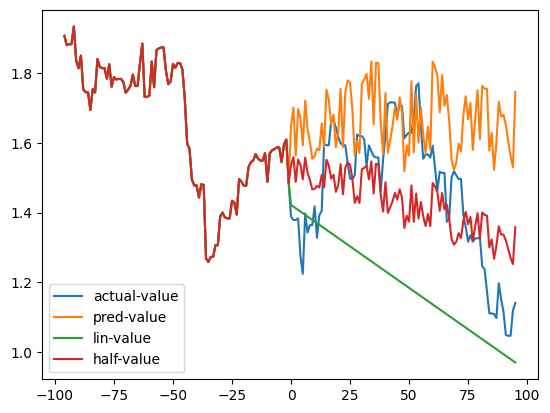

In [86]:
# 그래프 그리기
idx = 850
val = 7
xr = range(-96, 96)
y_prev = trues_te_tr2_test[idx-96, :, val]
y_pred = preds_te_tr2_test[idx, :, val]
y_true = trues_te_tr2_test[idx, :, val]
y_lin = preds_te_lin2_test[idx, :, val]
y_half = y_pred*0.5 + y_lin*0.5
plt.plot(xr, np.concatenate([y_prev, y_true]), label='actual-value')
plt.plot(xr, np.concatenate([y_prev, y_pred]), label='pred-value')
plt.plot(xr, np.concatenate([y_prev, y_lin]), label='lin-value')
plt.plot(xr, np.concatenate([y_prev, y_half]), label='half-value')
plt.legend()
plt.show()

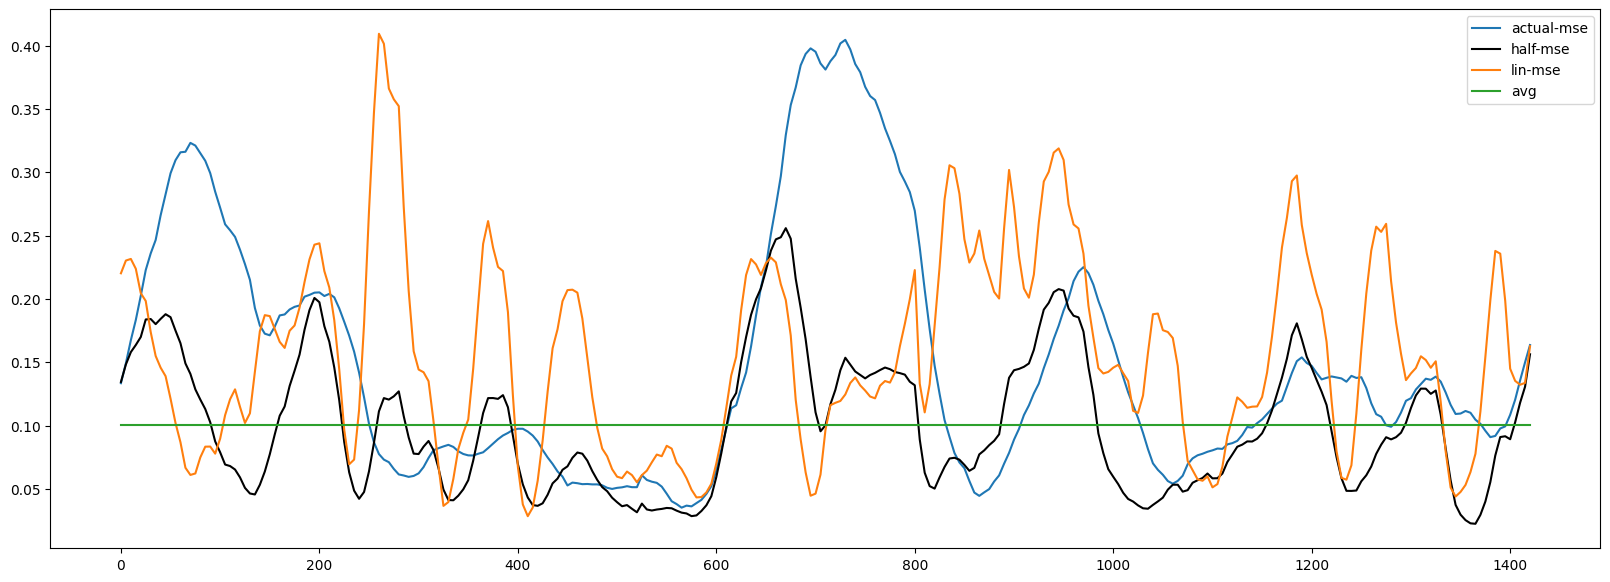

In [83]:
# MSE 평균분포 확인 의아함.
# 5 단위
mse_pred = []
mse_half_lin = []
mse_lin = []
for j in range(0, len(preds_te_tr2_test), 5):
    mse_pv = MSE(preds_te_tr2_test[j], trues_te_tr2_test[j])
    mse_hv = MSE(0.5*preds_te_tr2_test[j] + 0.5*preds_te_lin2_test[j], trues_te_tr2_test[j])
    mse_lv = MSE(preds_te_lin2_test[j], trues_te_tr2_test[j])
    mse_pred.append(mse_pv)
    mse_half_lin.append(mse_hv)
    mse_lin.append(mse_lv)

xv = range(0, len(preds_te_tr2_test), 5)
plt.figure(figsize=(20,7))
plt.plot(xv, mse_pred, label='actual-mse')
plt.plot(xv, mse_half_lin, 'k', label='half-mse')
plt.plot(xv, mse_lin, label='lin-mse')
plt.plot(xv, np.mean(mse_half_lin)*np.ones(len(xv)), label='avg')
plt.legend()
plt.show()